## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [ ]:
EXPERIMENT_NAME='CNN/5_dropout_03'
assert(not EXPERIMENT_NAME is None)

import tensorflow as tf
import uuid
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import warnings
import rasterio
import json
import glob
import shutil

# Reduce TF warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Activation, Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

%matplotlib inline
print(tf.config.list_physical_devices('GPU'))

In [ ]:
PROJECT_PATH = "/workspace/COMPUTERVISIONPROYECT"
DATASET_NAME = 'stratified'

# XVIEW_RECOGNITION_PATH = "./data/xview_recognition/"
XVIEW_RECOGNITION_PATH = os.path.join(PROJECT_PATH, "data/xview_recognition")

EXPERIMENT_PATH = os.path.join(PROJECT_PATH, "experiment_results", EXPERIMENT_NAME)
EXPERIMENT_RESULTS = os.path.join(EXPERIMENT_PATH, "results")
assert(not os.path.exists(EXPERIMENT_PATH))
if not os.path.exists(EXPERIMENT_PATH):
    os.mkdir(EXPERIMENT_PATH)
    os.mkdir(EXPERIMENT_RESULTS)
CHECKPOINT_DIR = os.path.join(EXPERIMENT_PATH, 'model_checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_WEIGHTS_FILENAME_PATTERN = os.path.join(CHECKPOINT_DIR, 'epoch_{epoch:03d}-val_loss_{val_loss:.4f}.keras')
MODEL_PATH = os.path.join(EXPERIMENT_PATH, 'model.keras')

CM_PATH = os.path.join(EXPERIMENT_RESULTS, 'cm.png')
METRICS_PATH = os.path.join(EXPERIMENT_RESULTS, 'metrics.csv')
ACC_LOSS_PATH = os.path.join(EXPERIMENT_RESULTS, 'acc_loss.png')
TEST_PREDICTS_PATH = os.path.join(EXPERIMENT_RESULTS, 'prediction.json')

TRAIN_SET_FILENAME = '_'.join([DATASET_NAME, 'train.tfrecord'])
VALIDATION_SET_FILENAME = '_'.join([DATASET_NAME, 'validation.tfrecord'])
TRAIN_SET_PATH = os.path.join(XVIEW_RECOGNITION_PATH, TRAIN_SET_FILENAME)
VALIDATION_SET_PATH = os.path.join(XVIEW_RECOGNITION_PATH, VALIDATION_SET_FILENAME)

## Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = None
DROPOUT_RATE = 0.3
REGULARIZER_PENALTY = None
DATA_AUGMENTATAION_RATE = 0.2
EPOCHS = 20

categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

# Required classes and functions

In [ ]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
def draw_confusion_matrix(cm, categories, save_path=None, exp_name=None):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3.2*pow(len(categories), 0.5), 2.4*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(15-pow(len(categories), 0.5)))
    fig.tight_layout()

    if save_path:
        if exp_name:
            plt.title(exp_name)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Gráfico guardado en: {save_path}")

    plt.show()

# 0. La usamos para las imágenes de test
def load_geoimage(filename_tensor):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    filename = filename_tensor
    src_raster = rasterio.open(filename, 'r')

    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

# 1. Función para decodificar los ejemplos del archivo
def _parse_image_function(example_proto):
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'category_id': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    
    features = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.io.decode_raw(features['image_raw'], out_type=tf.uint8)
    shape = [features['height'], features['width'], features['depth']]
    image = tf.reshape(image, shape)
    image = tf.cast(image, tf.float32)
    
    image = tf.image.resize(image, [224, 224])
    
    category_id = tf.cast(features['category_id'], tf.int32)
    label = tf.one_hot(category_id, depth=len(categories))
    
    return image, label

# 2. Función para crear el dataset
def create_tfrecord_dataset(filenames, batch_size, do_shuffle=False):
    # Lee los archivos TFRecord. Puede leer de múltiples archivos en paralelo.
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    
    if do_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Datasets definition

In [ ]:
train_dataset = create_tfrecord_dataset([TRAIN_SET_PATH], BATCH_SIZE, do_shuffle=True)
valid_dataset = create_tfrecord_dataset([VALIDATION_SET_PATH], BATCH_SIZE)

In [ ]:
y_train_labels = []
for _,label_idxs in train_dataset:
    y_train_labels += list(label_idxs.numpy().argmax(axis=1))

index,freqs = np.unique(y_train_labels, return_counts=True)
categories_count = pd.Series(freqs, index=[categories[idx] for idx in index], name='Size').sort_values(ascending=False)

categories_count

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(DATA_AUGMENTATAION_RATE),
    RandomZoom(DATA_AUGMENTATAION_RATE),
])

# Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [ ]:
model = Sequential(name=EXPERIMENT_NAME)
model.add(Input(shape=(224, 224, 3)))
model.add(data_augmentation)
model.add(Rescaling(1./255))

# Feature extraction layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), name='Pool1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), name='Pool2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), name='Pool3'))

model.add(Flatten(name='Flatten'))

model.add(Dropout(DROPOUT_RATE))

# Classification layer
model.add(Dense(512, activation='relu'))

model.add(Dense(len(categories), activation='softmax'))

model.summary()

In [ ]:
opt = Adam(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
model_checkpoint = ModelCheckpoint(
    filepath=BEST_WEIGHTS_FILENAME_PATTERN,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
terminate = TerminateOnNaN()
early_stop = EarlyStopping('val_accuracy', patience=EPOCHS, verbose=1, restore_best_weights=False)
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
print('Training model')
h = model.fit(train_dataset, 
              validation_data=valid_dataset, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

checkpoints = glob.glob(os.path.join(CHECKPOINT_DIR, '*.keras'))

if checkpoints:
    # Copiamos el mejor modelo en la ruta {EXPERIMENT_PATH}/model.keras
    # Ordenar los archivos por el valor de 'val_loss' (que está en el nombre)
    # y coger el primero (el que tenga el valor más bajo)
    BEST_WEIGHTS_FILENAME = min(checkpoints, key=lambda x: float(x.split('val_loss_')[1].replace('.keras', '')))
    model.load_weights(BEST_WEIGHTS_FILENAME)
    model.save(MODEL_PATH)

    print(f"El mejor modelo se encuentra en: {MODEL_PATH}")
else:
    print("No se encontraron checkpoints.")

# Validation
Compute validation metrics.

In [ ]:
predictions = model.predict(valid_dataset)
category_names = np.array(list(categories.values()))
y_pred = category_names[predictions.argmax(axis=1)]

y_true = []

for images_batch, labels_batch in valid_dataset:
    labels_np = labels_batch.numpy()
    
    true_indices = np.argmax(labels_np, axis=1)
    batch_labels = category_names[true_indices]
    
    y_true.extend(batch_labels)

Gráfico guardado en: /workspace/COMPUTERVISIONPROYECT/experiment_results/CNN/5_dropout_03/results/cm.png


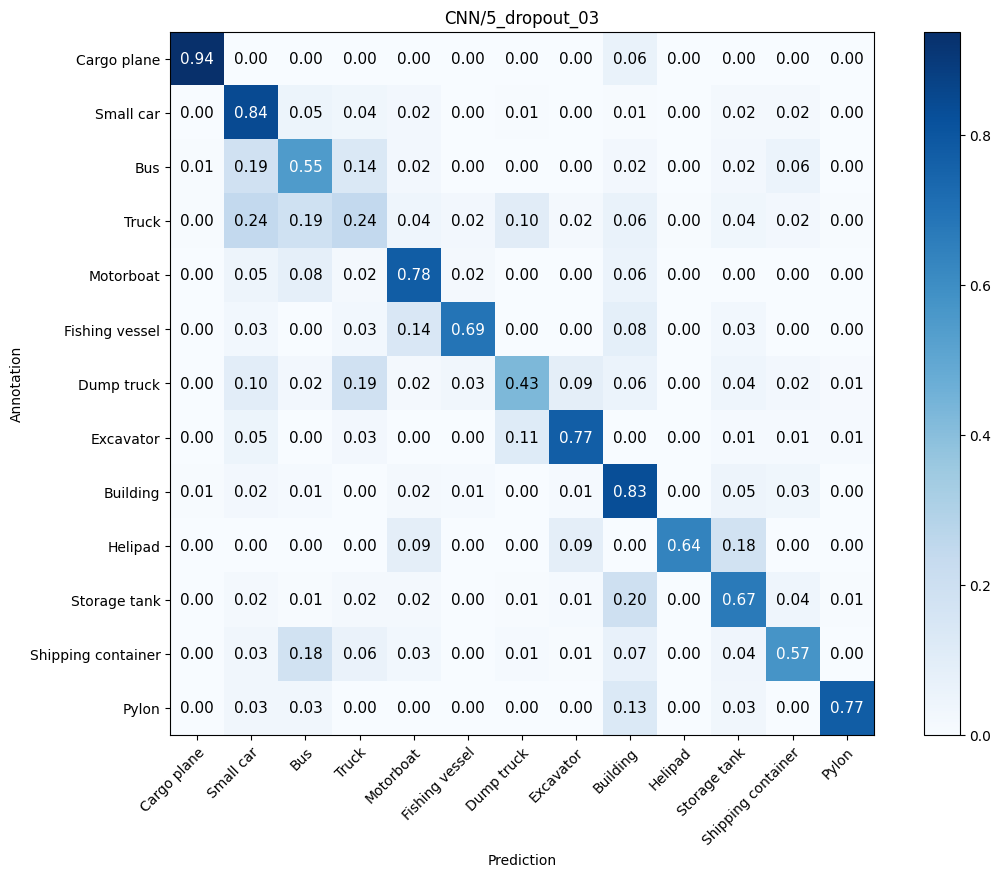

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories, CM_PATH, EXPERIMENT_NAME)

In [20]:
ll = []
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
global_acc = acc.mean()
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
global_recall = acc.mean()
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
global_precision = acc.mean()
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    ll.append(pd.Series([recall, precision, specificity, f1_score], name=categories[idx], index=["Recall", "Precision", "Specificity", "F1 Score"]))
ll = pd.DataFrame(ll)
sizes_col=pd.Series(y_true).value_counts()
sizes_col.name="Size"
ll = pd.concat([sizes_col, ll, pd.Series([EXPERIMENT_NAME for _ in categories], name='Experiment', index=categories.values())],axis=1)
ll.index.name='Category'
ll = ll.reset_index().set_index(['Experiment','Category'])
ll['Accuracy'] = np.nan
ll.loc[(EXPERIMENT_NAME, 'Global'), ['Size', 'Recall', 'Precision', 'Accuracy']] = [ll.Size.sum().astype(int), global_recall, global_precision, global_acc]
ll = ll.sort_values('Size', ascending=False)
ll.to_csv(METRICS_PATH)
ll.transpose()

Mean Accuracy: 66.667%
Mean Recall: 67.041%
Mean Precision: 69.210%


Experiment  CNN/5_dropout_03                                                  \
Category              Global    Building   Small car       Truck         Bus   
Size             1875.000000  359.000000  332.000000  221.000000  177.000000   
Recall              0.692100    0.830084    0.840361    0.244344    0.548023   
Precision           0.692100    0.774026    0.687192    0.409091    0.482587   
Specificity              NaN    0.942612    0.917693    0.952842    0.938751   
F1 Score                 NaN    0.801075    0.756098    0.305949    0.513228   
Accuracy            0.670409         NaN         NaN         NaN         NaN   

Experiment                                                           \
Category    Shipping container Storage tank  Dump truck   Motorboat   
Size                152.000000   147.000000  124.000000  107.000000   
Recall                0.572368     0.666667    0.427419    0.775701   
Precision             0.674419     0.653333    0.582418    0.638462   
Specificity           0.975624     0.969907    0.978298    0.973416   
F1 Score              0.619217     0.659933    0.493023    0.700422   
Accuracy                   NaN          NaN         NaN         NaN   

Experiment                                                               
Category     Excavator Fishing vessel Cargo plane      Pylon    Helipad  
Size         79.000000      71.000000   64.000000  31.000000  11.000000  
Recall        0.772152       0.690141    0.937500   0.774194   0.636364  
Precision     0.717647       0.765625    0.937500   0.800000   0.875000  
Specificity   0.986637       0.991685    0.997791   0.996746   0.999464  
F1 Score      0.743902       0.725926    0.937500   0.786885   0.736842  
Accuracy           NaN            NaN         NaN        NaN        NaN

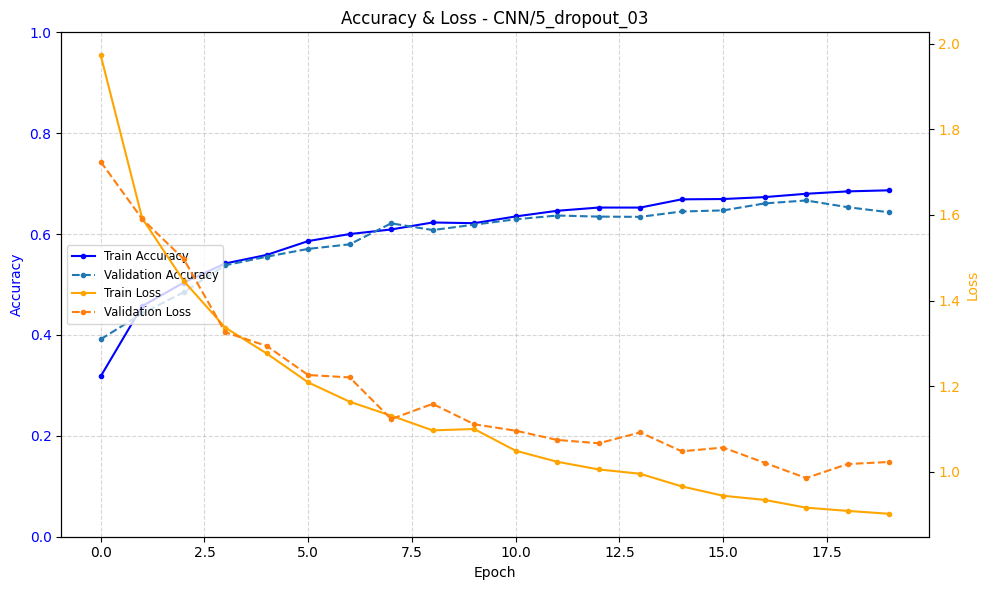

In [21]:
fig, ax1 = plt.subplots(figsize=(10, 6))

plt.title(f'Accuracy & Loss - {EXPERIMENT_NAME}')
ax1.set_xlabel('Epoch')

color_acc = 'blue'
ax1.set_ylabel('Accuracy', color=color_acc)
ax1.plot(h.history['accuracy'], label='Train Accuracy', color='blue', marker='.')
ax1.plot(h.history['val_accuracy'], label='Validation Accuracy', color='tab:blue', linestyle='--', marker='.')
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_ylim((0,1))

ax2 = ax1.twinx()  
color_loss = 'orange'
ax2.set_ylabel('Loss', color=color_loss)
ax2.plot(h.history['loss'], label='Train Loss', color='orange', marker='.')
ax2.plot(h.history['val_loss'], label='Validation Loss', color='tab:orange', linestyle='--', marker='.')
ax2.tick_params(axis='y', labelcolor=color_loss)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', frameon=True, fontsize='small')

fig.tight_layout()

plt.savefig(ACC_LOSS_PATH, bbox_inches='tight', dpi=300)

plt.show()

# Testing
Try to improve the results provided in the competition.

In [ ]:
anns = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(XVIEW_RECOGNITION_PATH, 'xview_test')):
    for filename in filenames:
        image = GenericImage(os.path.join(dirpath,filename))
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

In [ ]:
model = tf.keras.models.load_model(MODEL_PATH)
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [ ]:
with open(TEST_PREDICTS_PATH, "w") as outfile:
    json.dump(predictions_data, outfile)